In [1]:
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from keras import layers

In [6]:
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

In [7]:
from google.colab import files

In [8]:
(train_ds, validation_ds, test_ds), info = tfds.load(
    "colorectal_histology",
    split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
    with_info=True,
    as_supervised=True,
    shuffle_files= True,
)

num_classes = info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/2.0.0.incomplete3ZIJ9X/colorectal_histology-train.tfr…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [9]:
size = (150, 150)
batch_size = 32

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [10]:
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [11]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),    
    layers.RandomRotation(0.1),
    ])

In [12]:
base_model = keras.applications.resnet_v2.ResNet50V2(
    weights="imagenet",
    input_shape=(150, 150, 3),
    include_top=False,
)

94668760/94668760 [==============================] - 1s 0us/step


In [13]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']    

In [14]:
base_model.trainable = False

In [15]:
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)

scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

In [16]:
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [17]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True,
    verbose=1
    )

In [18]:
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [19]:
epochs = 500
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[callback])

Epoch 1/500
125/125 [==============================] - 315s 2s/step - loss: 0.7922 - accuracy: 0.7295 - val_loss: 0.4399 - val_accuracy: 0.8620
Epoch 2/500
125/125 [==============================] - 299s 2s/step - loss: 0.4648 - accuracy: 0.8378 - val_loss: 0.3799 - val_accuracy: 0.8720
Epoch 3/500
125/125 [==============================] - 301s 2s/step - loss: 0.4147 - accuracy: 0.8515 - val_loss: 0.3494 - val_accuracy: 0.8880
Epoch 4/500
125/125 [==============================] - 300s 2s/step - loss: 0.3663 - accuracy: 0.8737 - val_loss: 0.3356 - val_accuracy: 0.8820
Epoch 5/500
125/125 [==============================] - 299s 2s/step - loss: 0.3330 - accuracy: 0.8842 - val_loss: 0.3261 - val_accuracy: 0.9000
Epoch 6/500
125/125 [==============================] - 302s 2s/step - loss: 0.3256 - accuracy: 0.8815 - val_loss: 0.3132 - val_accuracy: 0.9000
Epoch 7/500
125/125 [==============================] - 297s 2s/step - loss: 0.3057 - accuracy: 0.8910 - val_loss: 0.2921 - val_accuracy:

In [20]:
score = model.evaluate(train_ds, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20241062343120575
Test accuracy: 0.9282500147819519


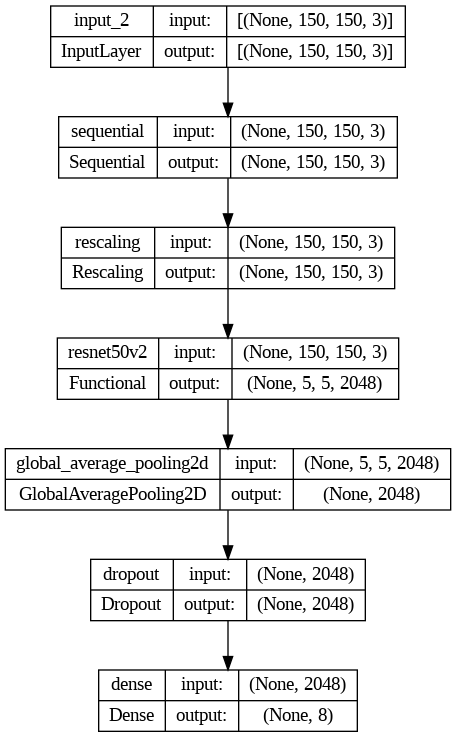

In [21]:
keras.utils.plot_model(model,show_shapes=True)

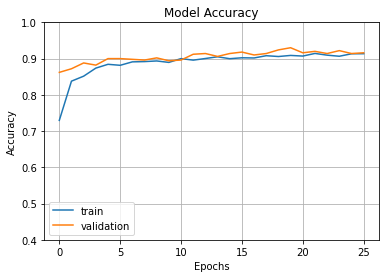

In [22]:

fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()
     


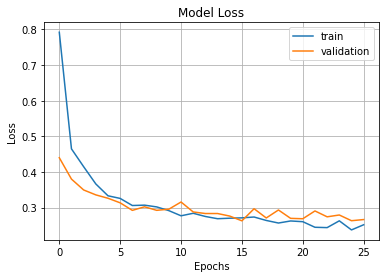

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [24]:
model.save('model.h5')

In [25]:
try:
  files.download('./model.h5')
except ImportError:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>